In [2]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

In [3]:
# Loading & Preprocessing

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader(r'C:\Users\Vicky\Documents\ML\skin-cancer-master\images\benign',224))

malign_train = np.array(Dataset_loader(r'C:\Users\Vicky\Documents\ML\skin-cancer-master\images\malign',224))
benign_test = np.array(Dataset_loader(r'C:\Users\Vicky\Documents\ML\skin-cancer-master\images\test\benign',224))
malign_test = np.array(Dataset_loader(r'C:\Users\Vicky\Documents\ML\skin-cancer-master\images\test\malign',224))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 15.87it/s]


# Create Label

In [4]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

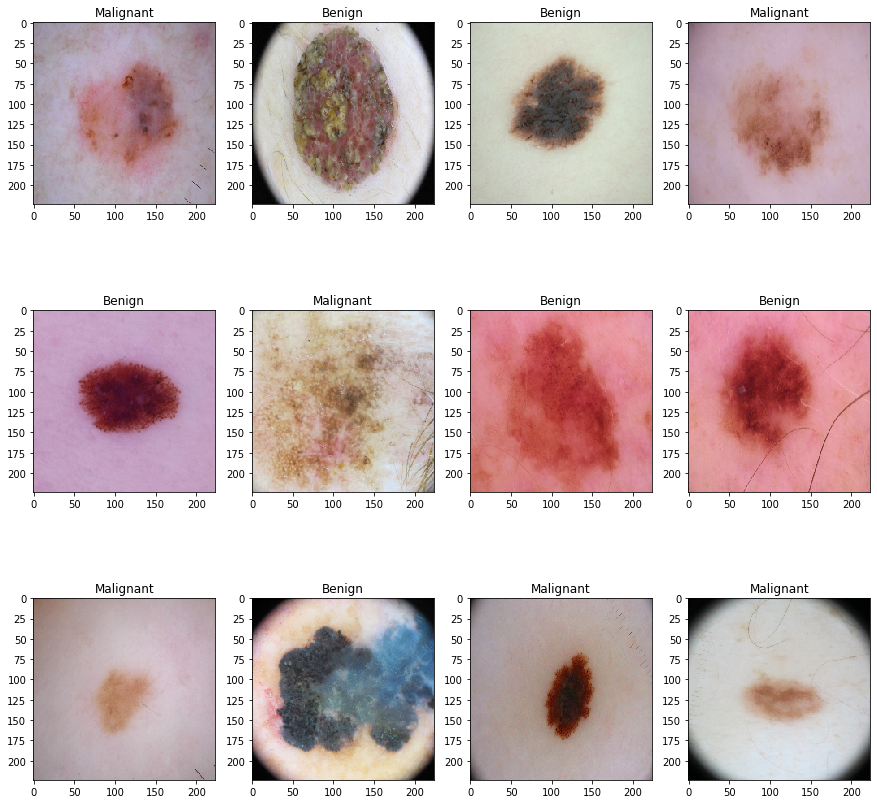

In [6]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [7]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Model: EfficientNetB0 -Adam

In [12]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [13]:
 from tensorflow.python.types import core as core_tf_types

In [14]:
K.clear_session()
gc.collect()

B0 =  EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(B0 ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,057,253
Trainable params: 4,012,670
Non-trainable params: 44,583
_________________________________________________________________


In [15]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights1.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [16]:
import h5py

In [17]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
28/27 [==============================] - ETA: -5s - loss: 0.7920 - accuracy: 0.6211
Epoch 00001: val_accuracy improved from -inf to 0.57658, saving model to weights1.best.hdf5
28/27 [==============================] - 677s 24s/step - loss: 0.7920 - accuracy: 0.6211 - val_loss: 0.7495 - val_accuracy: 0.5766
Epoch 2/30
28/27 [==============================] - ETA: -5s - loss: 0.6354 - accuracy: 0.7083
Epoch 00002: val_accuracy improved from 0.57658 to 0.59234, saving model to weights1.best.hdf5
28/27 [==============================] - 661s 24s/step - loss: 0.6354 - accuracy: 0.7083 - val_loss: 0.8127 - val_accuracy: 0.5923
Epoch 3/30
28/27 [==============================] - ETA: -5s - loss: 0.6388 - accuracy: 0.7134
Epoch 00003: val_accuracy improved from 0.59234 to 0.62613, saving model to weights1.best.hdf5
28/27 [==============================] - 637s 23s/step - loss: 0.6388 - accuracy: 0.7134 - val_

28/27 [==============================] - ETA: -5s - loss: 0.4311 - accuracy: 0.7973
Epoch 00026: val_accuracy did not improve from 0.84009
28/27 [==============================] - 636s 23s/step - loss: 0.4311 - accuracy: 0.7973 - val_loss: 0.3435 - val_accuracy: 0.8401
Epoch 27/30
28/27 [==============================] - ETA: -5s - loss: 0.4178 - accuracy: 0.8029
Epoch 00027: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 00027: val_accuracy did not improve from 0.84009
28/27 [==============================] - 630s 22s/step - loss: 0.4178 - accuracy: 0.8029 - val_loss: 0.3443 - val_accuracy: 0.8401
Epoch 28/30
28/27 [==============================] - ETA: -5s - loss: 0.3972 - accuracy: 0.8097
Epoch 00028: val_accuracy did not improve from 0.84009
28/27 [==============================] - 613s 22s/step - loss: 0.3972 - accuracy: 0.8097 - val_loss: 0.3441 - val_accuracy: 0.8401
Epoch 29/30
28/27 [==============================] - ETA: -5s - loss: 0.4254 - accura

In [18]:
with open('history1.json', 'w') as f:
    json.dump(str(history.history), f)

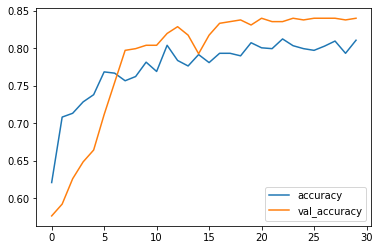

In [19]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

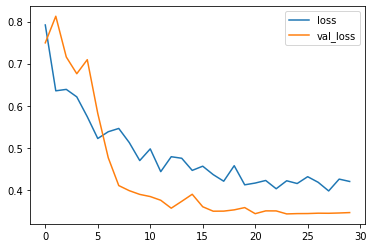

In [20]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [21]:
model.load_weights("weights1.best.hdf5")

In [22]:
Y_val_pred = model.predict(x_val)

In [23]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8400900900900901

In [24]:
Y_pred = model.predict(X_test)

In [25]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:27<00:00, 38.75s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[448 140]
 [ 21 279]]


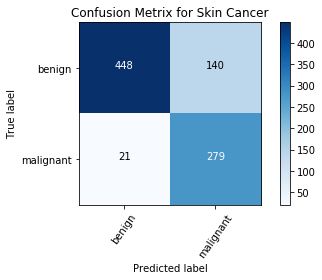

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[400 188]
 [  6 294]]


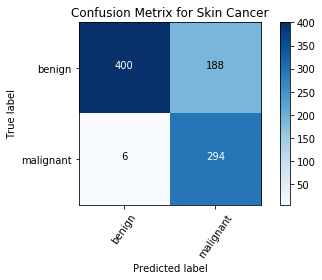

In [27]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [28]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.99      0.68      0.80       588\n           1       0.61      0.98      0.75       300\n\n    accuracy                           0.78       888\n   macro avg       0.80      0.83      0.78       888\nweighted avg       0.86      0.78      0.79       888\n'

### ROC and AUC

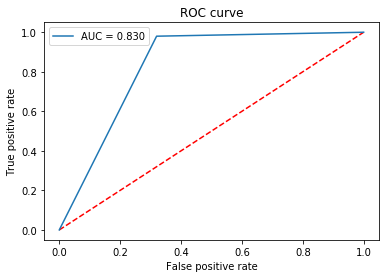

In [29]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

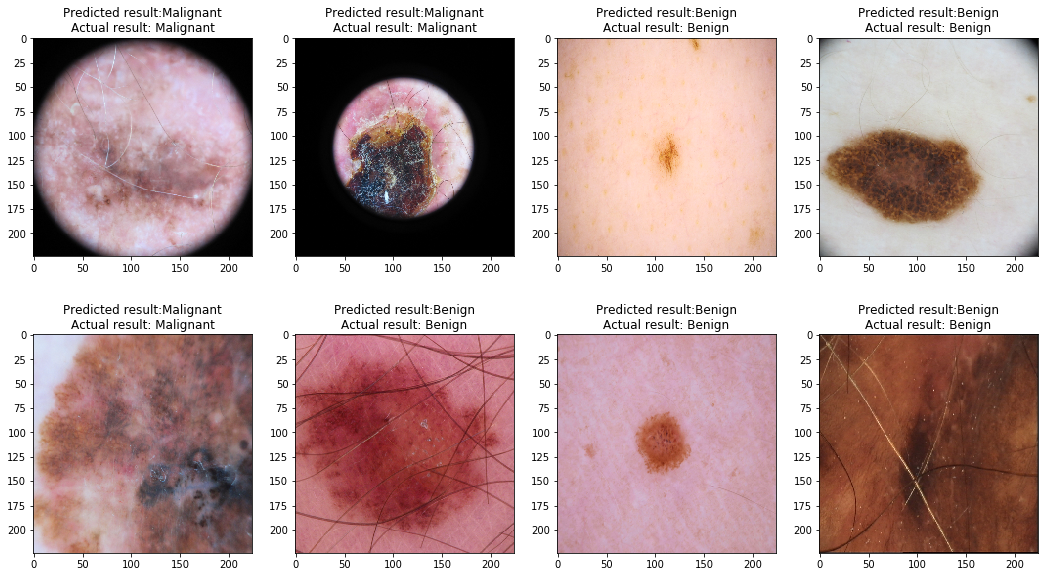

In [30]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()